In [167]:
%matplotlib inline

In [168]:
import datetime
import pandas as pd
import numpy as np
import datetime

In [169]:
import catboost
from catboost import CatBoostClassifier, Pool, cv
import hyperopt

In [170]:
import tqdm

In [171]:
from sklearn.pipeline import Pipeline
import sklearn.model_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import model_selection , metrics   #Additional scklearn functions

## import and parameters

In [198]:
imput_strategy = 1

In [199]:
train = pd.read_pickle('../data/merged_data/train.pkl')
test = pd.read_pickle('../data/merged_data/test.pkl')

In [200]:
#train = train.sample(frac=0.1)

In [201]:
# preprocess
y_train = train['target'].values

# to try:
* optimize aucroc with keras and batch methods
* SVM / rank SVM (https://github.com/rdipietro/pyrvm)
* try separate models on separate variables + stacking

## Features : 
* NLP on COMMENTAIRE_BI
* Extract options from OPTION (pas sur que ce soit util, peut être juste check la qualité)
* features from history



* check for intervention in test without contracts and to handle them
* add combinations of categorical features (see paribas example on catboost site)
* select only best features (feature_importance ?)
* try to put random nas in train for handling missing contracts

## Fails:
* one model with selectKbest on modalities vs one model on dimensionality reduction with group rare modalities
    * dimensionality reduction don't bring much value here (mb MCA)
    * select k best fails with 5k categories, which is not enough to be interesting

In [202]:
drop = ['INSTANCE_ID', #460k modalities, not usable as a feature
        'INCIDENT_NUMBER']
drop_atm = [#'AUTEUR_INCIDENT', # 2088 modalities
            'TYPE_VOIE',
#            'NATURE_CODE', # 313 modalities, need to be splitted in 5 modalities
#            'MARQUE_LIB', # 167 modalities
#            'OPTION', # 80 modalities, extract options
#            'MODELE_CODE', # 10k modalities
#            'COMMENTAIRE_BI', # NLP 400k modalities
#             'RESOURCE_ID', # 4033 modalities
            'CODE_POSTAL', # 5800 modalities (only get first 2 numbers ?)
            'L2_ORGA_CODE_POSTAL', # 147 modalities (might be redondent with L2_ORGANISATION_ID)
#            'L2_ORGANISATION_ID' #151 modalities
            'L2_ORGA_VILLE', # 146, might be redondent with other organisation variables
#            'RACHAT_CODE' # 312 modalities (try binarising ?)         
#            'CODE_INSTALLATION' # 17 modalities
           ]

In [203]:
train.drop(drop + drop_atm + ['target'], axis=1, inplace=True)
test.drop(drop + drop_atm, axis=1, inplace=True)

In [204]:
categoricals = list(train.columns[train.dtypes == 'category'])

### imputation of missing data

TODO: try imputing test based on test values, not train <br>
TODO: try diffrent strategy on imputing datas from contract since missing are present only in test set<BR>
TODO: try creating data with missing contract in train sample and do not fill the missing in test<br>
TODO: try imputing specific na value for categorical variables

In [205]:
def impute_selected_variables(df, test, categ, quanti, dates):
    _df = df.copy()
    _test = test.copy() if test is not None else None
    
    replace = _df[categ].mode()
    replace_values = {k:v.iloc[0] for k,v in replace.items()}
    _df.fillna(replace_values, inplace=True)

    replace_quanti = _df[quanti].mean()
    _df.fillna(replace_quanti, inplace=True)

    _df[dates] = _df[dates].fillna(method='pad')
    
    if test is not None:
        
        _test.fillna(replace_values, inplace=True)
        _test.fillna(replace_quanti, inplace=True)
        _test[dates] = _df[dates].fillna(method='pad')
    
    return _df, _test

In [206]:
#replace = train[categoricals].mode()
#replace_values = {k:v.iloc[0] for k,v in replace.items()}
def impute_contract_variables(df):
    _df = df.copy()
    
    for var in categ_contract:
        _df[var] = _df[var].cat.add_categories(['NAN'])
        _df[var].fillna('NAN', inplace=True)

    _df[quanti_contract] = _df[quanti_contract].fillna(-9999)
    _df[date_contract] = _df[date_contract].fillna(datetime.datetime(1970, 1, 1))
    return _df

In [207]:
categoricals = list(train.columns[train.dtypes == 'category'])
quantitative = ['NB_PASSAGE', 'POINTS_FIDEL', 'CONTRAT_TARIF', 'PRIX_FACTURE']
dates = list(train.columns[train.dtypes == 'datetime64[ns]'])

In [208]:
contract_variables = [ 'UPD_DATE', 'DATE_DEBUT', 'DATE_FIN', 'STS_CODE', 'OPTION', 'FORMULE', 'CONTRAT_TARIF', 'PRIX_FACTURE']

In [209]:
#impute without contract
categ_to_impute = list(set(categoricals) - set(contract_variables))
quanti_to_impute = list(set(quantitative) - set(contract_variables))
date_to_impute = list(set(dates) - set(contract_variables))

In [210]:
#impute contract
categ_contract = list(set(categoricals).intersection(set(contract_variables)))
quanti_contract = list(set(quantitative).intersection(set(contract_variables)))
date_contract = list(set(dates).intersection(set(contract_variables)))

In [211]:
#train and test are filled with values taken from train
#contract and other variables are imputed together
if imput_strategy == 1:
    train, test = impute_selected_variables(train, test, categoricals, quantitative, dates)

In [212]:
#train and test are filled with values taken on their own values
#contract and other variables are imputed together
if imput_strategy == 2:
    train, _ = impute_selected_variables(train, None, categoricals, quantitative, dates)
    test, _ = impute_selected_variables(test, None, categoricals, quantitative, dates)

In [213]:
#train and test are filled with values taken from train
#contract and other variables are imputed separatly (need to import some NAN in train set)
if imput_strategy == 3:
    train, test = impute_selected_variables(train, test, categ_to_impute, quanti_to_impute, date_to_impute)
    train = impute_contract_variables(train)
    test = impute_contract_variables(test)

In [214]:
# train and test are filled on their own values
# contract and other variables are imputed separatly (need to import some NAN in train set)
if imput_strategy == 4:
    train, _ = impute_selected_variables(train, None, categ_to_impute, quanti_to_impute, date_to_impute)
    test, _ = impute_selected_variables(test, None, categ_to_impute, quanti_to_impute, date_to_impute)
    train = impute_contract_variables(train)
    test = impute_contract_variables(test)

### Feature ingineering

In [215]:
def commentaire_bi(df):
    _df = df.copy()
    
    _df.COMMENTAIRE_BI = _df.COMMENTAIRE_BI.str.upper()
    COMMENTAIRE_BI_vc = _df.COMMENTAIRE_BI.value_counts()
    common_commentaire_bi = COMMENTAIRE_BI_vc[COMMENTAIRE_BI_vc > 100].index
    _df['COMMENTAIRE_BI_common'] = _df.COMMENTAIRE_BI.where(_df.COMMENTAIRE_BI.isin(common_commentaire_bi), "Rare")
    _df['COMMENTAIRE_BI_common'] = _df['COMMENTAIRE_BI_common'].astype('category')
    
    _df['nb_char_commentaire'] = [len(txt) for txt in _df.COMMENTAIRE_BI]
    _df['nb_mots_commentaire'] = [len(txt.split()) for txt in _df.COMMENTAIRE_BI]
    _df['has_number_commentaire'] = [any(char.isdigit() for char in txt) for txt in _df.COMMENTAIRE_BI]
    _df['is_empty_commentaire'] = [(txt == '.') for txt in _df.COMMENTAIRE_BI]
    _df.drop('COMMENTAIRE_BI', axis=1, inplace=True)
    
    return _df

In [216]:
def nature_code_split(df):
    _df = df.copy()
    nature_code_splitted = [nc.split('-') for nc in df.NATURE_CODE]
    nature_code_df = pd.DataFrame(nature_code_splitted, columns=['nc_1', 'nc_2', 'nc_3', 'nc_4', 'nc_5'])
    nature_code_df.fillna('-1', inplace=True)
    for nc_i in ['nc_1', 'nc_2', 'nc_3', 'nc_4', 'nc_5']:
        nature_code_df[nc_i] = nature_code_df[nc_i].astype('category')
    
    #_df.drop('NATURE_CODE', axis=1, inplace=True)
    _df = _df.merge(nature_code_df, left_index=True, right_index=True)
    return _df

In [217]:
# todo: use dt series accessor
def add_dates_features(data):
    data['age_installation'] = (data['CRE_DATE_GZL'] - data['INSTALL_DATE']).dt.days // 365
    data['mois_appel'] = data['CRE_DATE_GZL'].map(lambda x: x.month)
    data['joursemaine_appel'] = data['CRE_DATE_GZL'].map(lambda x: x.isoweekday()) #integer, might be considered categorical
    data['jour_appel'] = data['CRE_DATE_GZL'].map(lambda x: x.day)
    data['mois_intervention'] = data['SCHEDULED_START_DATE'].map(lambda x: x.month)
    data['joursemaine_intervention'] = data['SCHEDULED_START_DATE'].map(lambda x: x.isoweekday()) #integer, might be considered categorical
    data['jour_intervention'] = data['SCHEDULED_START_DATE'].map(lambda x: x.day)
    data['duree_avant_intervention'] = (data['SCHEDULED_START_DATE'] - data['CRE_DATE_GZL']).dt.days
    data['duree_prevue'] = (data['SCHEDULED_END_DATE'] - data['SCHEDULED_START_DATE']).dt.days
    data['temps_depuis_debut_contrat'] = (data['CRE_DATE_GZL'] - data['DATE_DEBUT']).dt.days
    data['temps_jusqua_fin_contrat'] = (data['CRE_DATE_GZL'] - data['DATE_FIN']).dt.days  #souvent nan ? (mettre 0)
    data['temps_depuis_maj_contrat'] = (data['CRE_DATE_GZL'] - data['UPD_DATE']).dt.days 

    data.drop(['CRE_DATE_GZL', 'INSTALL_DATE', 'SCHEDULED_START_DATE', 'SCHEDULED_END_DATE', 'DATE_DEBUT', 'DATE_FIN', 'UPD_DATE'], axis=1, inplace=True)
    return data

In [218]:
#mots en particulier
#créer un dictionnaire et compter (count et garder les must ? voir la diff entre les cas + et - ?)

In [219]:
# feature engineering

# (history) temps depuis dernière visite (pas forcément dispo sur le test)
# (history) déjà eu une casse sur ce matériel
# (history) temps depuis dernière casse
# (history) la dernière visite date de moins de 6 mois
# (history) nb interventions faires par la ressource
# (history) temps depuis la première intervention de la ressource
# (contract history) nb de fois que le contrat a été mis à jour sur les X dernières années

In [220]:
train = commentaire_bi(train)
train = nature_code_split(train)
train = add_dates_features(train)

In [221]:
test = commentaire_bi(test)
test = nature_code_split(test)
test = add_dates_features(test)

In [222]:
#drop variables
drop = ['joursemaine_appel', 
'USAGE_LOCAL', 
'nc_4', 
'is_empty_commentaire', 
'duree_prevue', 
'nc_1']

train.drop(drop, axis=1,inplace=True)
test.drop(drop, axis=1,inplace=True)

## Get variables where test set has modalities which are not in train set

In [151]:
categoricals = list(train.columns[train.dtypes == 'category'])
var_with_new_categ = []
for cat in categoricals:
    if len(set(test[cat]) - set(train[cat])) > 0:
        var_with_new_categ.append(cat)

# drop categories in test which are not in train

In [32]:
for cat in categoricals:
    train[cat] = train[cat].cat.remove_unused_categories()

In [33]:
class CategoriesDroper(BaseEstimator, TransformerMixin):
    '''Drop categories which are not in the train set'''

    def __init__(self, columns):
        self.columns = columns
        self.categories_dict = dict()
        
    def fit(self, df, y=None):
        self.categories_dict = {column: df[column].cat.categories for column in self.columns}
        return self

    def transform(self, df):
        _df = df.copy()
        for column in self.columns:
            _df[column] = _df[column].cat.set_categories(self.categories_dict[column])
            try:
                _df[column] = _df[column].fillna('NAN')
            except ValueError as e:
                _df[column] = _df[column].cat.add_categories(['NAN'])
                _df[column] = _df[column].fillna('NAN') 
                print(e,'with ', column)
        
        return _df

In [34]:
cd = CategoriesDroper(categoricals)
cd.fit(train)
test = cd.transform(test)

fill value must be in categories with  INCIDENT_TYPE_ID
fill value must be in categories with  TYPE_BI
fill value must be in categories with  MILLESIME
fill value must be in categories with  PROBLEM_CODE
fill value must be in categories with  AUTEUR_INCIDENT
fill value must be in categories with  GRAVITE
fill value must be in categories with  RESOURCE_ID
fill value must be in categories with  TYPE_OCC
fill value must be in categories with  RACHAT_CODE
fill value must be in categories with  NATURE_CODE
fill value must be in categories with  MARQUE_LIB
fill value must be in categories with  MODELE_CODE
fill value must be in categories with  PAYS
fill value must be in categories with  STOP_PHONING
fill value must be in categories with  CODE_GEN_EQUIPEMENT
fill value must be in categories with  CODE_FONCTION
fill value must be in categories with  CODE_ENERGIE
fill value must be in categories with  CODE_INSTALLATION
fill value must be in categories with  CODE_SPECIFICATION
fill value must b

# Modelisation

TODO:
* one hot encoding low modalities: keep for grid search (no ideal value found right now, try 3, 5, ... 9)
* group rare modalities: doesn't seem to improve the model

### split train / val

In [ ]:
#for item in categoricals:
#    train[item] = train[item].cat.codes +1

In [152]:
# split train in train, cv (will be replaced by cross validation for parameters tuning)
# stratify ?
X_train_train, X_train_val, y_train_train, y_train_val = sklearn.model_selection.train_test_split(train, y_train, random_state=101)

In [153]:
pos_neg_ratio =  sum(y_train==0) / sum(y_train)

In [154]:
#combinations_ctr for list of variables ?
model = CatBoostClassifier(
    iterations=200,
#    one_hot_max_size=3,
#    learning_rate=0.16,
#    depth=8,
    eval_metric="AUC",
    random_seed=42,
    od_type='Iter',
    od_wait=40,
    use_best_model=True
#    scale_pos_weight=pos_neg_ratio
)

In [155]:
categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [X_train_train.columns.get_loc(cat) for cat in categoricals]

In [156]:
model.fit(
    X_train_train, y_train_train,
    cat_features=categorical_features_indices,
    eval_set=(X_train_val, y_train_val),
    logging_level='Verbose'  # you can uncomment this for text output
)

Learning rate set to 0.312918
0:	test: 0.6943127	best: 0.6943127 (0)	total: 2.63s	remaining: 8m 42s
1:	test: 0.7005919	best: 0.7005919 (1)	total: 5.4s	remaining: 8m 54s
2:	test: 0.7020297	best: 0.7020297 (2)	total: 7.53s	remaining: 8m 14s
3:	test: 0.7060922	best: 0.7060922 (3)	total: 10.4s	remaining: 8m 28s
4:	test: 0.7154319	best: 0.7154319 (4)	total: 12.9s	remaining: 8m 22s
5:	test: 0.7197584	best: 0.7197584 (5)	total: 15.2s	remaining: 8m 10s
6:	test: 0.7222481	best: 0.7222481 (6)	total: 18.1s	remaining: 8m 20s
7:	test: 0.7229336	best: 0.7229336 (7)	total: 20.7s	remaining: 8m 16s
8:	test: 0.7258719	best: 0.7258719 (8)	total: 24s	remaining: 8m 30s
9:	test: 0.7263257	best: 0.7263257 (9)	total: 26.5s	remaining: 8m 23s
10:	test: 0.7291159	best: 0.7291159 (10)	total: 30s	remaining: 8m 35s
11:	test: 0.7292731	best: 0.7292731 (11)	total: 32.8s	remaining: 8m 33s
12:	test: 0.7295430	best: 0.7295430 (12)	total: 35.9s	remaining: 8m 36s
13:	test: 0.7297553	best: 0.7297553 (13)	total: 38.4s	remai

113:	test: 0.7515367	best: 0.7515376 (110)	total: 5m 28s	remaining: 4m 7s
114:	test: 0.7515229	best: 0.7515376 (110)	total: 5m 31s	remaining: 4m 4s
115:	test: 0.7515537	best: 0.7515537 (115)	total: 5m 34s	remaining: 4m 2s
116:	test: 0.7517499	best: 0.7517499 (116)	total: 5m 37s	remaining: 3m 59s
117:	test: 0.7517546	best: 0.7517546 (117)	total: 5m 40s	remaining: 3m 56s
118:	test: 0.7517617	best: 0.7517617 (118)	total: 5m 43s	remaining: 3m 53s
119:	test: 0.7518061	best: 0.7518061 (119)	total: 5m 45s	remaining: 3m 50s
120:	test: 0.7530772	best: 0.7530772 (120)	total: 5m 49s	remaining: 3m 48s
121:	test: 0.7530983	best: 0.7530983 (121)	total: 5m 51s	remaining: 3m 45s
122:	test: 0.7531698	best: 0.7531698 (122)	total: 5m 55s	remaining: 3m 42s
123:	test: 0.7531916	best: 0.7531916 (123)	total: 5m 57s	remaining: 3m 39s
124:	test: 0.7532120	best: 0.7532120 (124)	total: 6m	remaining: 3m 36s
125:	test: 0.7532843	best: 0.7532843 (125)	total: 6m 3s	remaining: 3m 33s
126:	test: 0.7532846	best: 0.7532

199:	test: 0.7686368	best: 0.7686409 (198)	total: 14m 41s	remaining: 0us (nlp, lr=0.31)
199:	test: 0.7686109	best: 0.7686109 (199)	total: 14m 17s	remaining: 0us (nlp, lr=0.31, 9 variables dropped)
199:	test: 0.7729298	best: 0.7730353 (190)	total: 22m 13s	remaining: 0us (nlp, lr=0.31, 6 variables dropped, depth=8)
199:	test: 0.7576144	best: 0.7576257 (197)	total: 15m 42s	remaining: 0us(nlp, lr=0.31, weighted, one_hot=3)

### Feature importance

In [157]:
importances=model.feature_importances_

In [158]:
indices = np.argsort(model.feature_importances_)[::-1]

print("Feature ranking:")

for f in range(train.shape[1]):
    print("%d. %s (%f)" % (f + 1, train.columns[indices[f]], model.feature_importances_[indices[f]]))

Feature ranking:
1. MODELE_CODE (11.118470)
2. L2_ORGANISATION_ID (10.799208)
3. mois_intervention (10.283465)
4. INCIDENT_TYPE_ID (9.535226)
5. nb_char_commentaire (6.651571)
6. MILLESIME (5.435368)
7. duree_avant_intervention (4.610956)
8. COMMENTAIRE_BI_common (4.425627)
9. FORMULE (4.378184)
10. GRAVITE (3.687602)
11. TYPE_BI (3.242041)
12. AUTEUR_INCIDENT (2.390694)
13. mois_appel (2.344770)
14. PRIX_FACTURE (1.917425)
15. ORIGINE_INCIDENT (1.774946)
16. age_installation (1.591261)
17. CODE_FONCTION (1.457046)
18. MARQUE_LIB (1.401068)
19. NB_PASSAGE (1.348950)
20. NATURE_CODE (1.241835)
21. STS_CODE (1.197649)
22. CONTRAT_TARIF (0.819001)
23. OPTION (0.694866)
24. STOP_PHONING (0.674549)
25. L1_ORGANISATION_ID (0.671432)
26. joursemaine_intervention (0.650854)
27. POINTS_FIDEL (0.555872)
28. CODE_GEN_EQUIPEMENT (0.545933)
29. nb_mots_commentaire (0.518999)
30. temps_jusqua_fin_contrat (0.473289)
31. temps_depuis_maj_contrat (0.468931)
32. jour_intervention (0.453002)
33. temps_de

In [159]:
import matplotlib.pyplot as plt

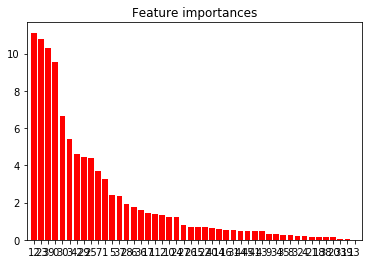

In [160]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(train.shape[1]), indices)
plt.xlim([-1, train.shape[1]])
plt.show()

### Hyperparameter tunning

In [ ]:
categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

#### GridSearch

In [ ]:
from sklearn.grid_search import GridSearchCV

In [ ]:
#what to do with cat features
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.20, 0.31, 0.40],
         'l2_leaf_reg': [1, 4, 9],
         'iterations': [300]}
cb = CatBoostClassifier()
cb_model = GridSearchCV(cb, params, scoring="roc_auc")
cb_model.fit(train, y_train, cb__cat_features=categorical_features_indices)

#### hyperopt

In [ ]:
def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=int(params['iterations']),
        border_count=int(params['border_count']),
        eval_metric='AUC',
        random_seed=42,
        logging_level='Silent'
        #od_type='Iter',
        #od_wait=40
    )
    
    cv_data = cv(
        Pool(train, y_train, cat_features=categorical_features_indices),
        model.get_params(),
        stratified=True,
        fold_count=5
    )
    best_AUC = np.max(cv_data['test-AUC-mean'])
    print(params, 'best_AUC: ', best_AUC)
    
    return 1 - best_AUC # as hyperopt minimises

In [ ]:
#param space example for xgboost
#    space = {
#             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
#             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
#             'max_depth' : hp.quniform('max_depth', 1, 13, 1),
#             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
#             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
#             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
#             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#             'num_class' : 9,
#             'eval_metric': 'mlogloss',
#             'objective': 'multi:softprob',
#             'nthread' : 6,
#             'silent' : 1
#}

In [ ]:
from numpy.random import RandomState

params_space = {
    #'l2_leaf_reg': hyperopt.hp.loguniform('l2_leaf_reg', -1, np.log(50)),
    'l2_leaf_reg': hyperopt.hp.choice('l2_leaf_reg', [11.47871028241772]),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-1, 8e-1),
     #'learning_rate': hyperopt.hp.choice('learning_rate', [0.31]),
    'iterations': hyperopt.hp.quniform('iterations', 250, 1000, 1),
    #'iterations': hyperopt.hp.choice('iterations', [250]),
    #'depth': hyperopt.hp.quniform('depth', 3, 9, 1),
    'depth': hyperopt.hp.choice('depth', [7]),
#    'ctr_border_count': hyperopt.hp.quniform('ctr_border_count', 32, 255, 1),
    #'border_count': hyperopt.hp.quniform('border_count', 16, 255, 1)
    'border_count': hyperopt.hp.choice('border_count', [213])
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=8,
    trials=trials,
    rstate=RandomState(123)
    
)

print(best)

#round 1
{'depth': 7.0, 'l2_leaf_reg': 6.687638927479829} best_AUC:  0.764339203919555
{'depth': 8.0, 'l2_leaf_reg': 2.238434810070511} best_AUC:  0.7641940842160905
{'depth': 9.0, 'l2_leaf_reg': 15.61615505112418} best_AUC:  0.7656179177534072
{'depth': 7.0, 'l2_leaf_reg': 11.47871028241772} best_AUC:  0.766724797438951
{'depth': 6.0, 'l2_leaf_reg': 2.0946141383866816} best_AUC:  0.7641940842160905
{'depth': 5.0, 'l2_leaf_reg': 3.409700409045487} best_AUC:  0.7656396435014416
{'l2_leaf_reg': 11.47871028241772, 'learning_rate': 7.0}

#round 2
{'border_count': 199.0, 'depth': 7, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7654693707749893
{'border_count': 213.0, 'depth': 7, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7662068818039395
{'border_count': 105.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7639026943327258
{'border_count': 238.0, 'depth': 7, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.764574925126635
{'border_count': 22.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7643064612539859
{'border_count': 103.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7632638136706521
{'border_count': 225.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7653002122083675
{'border_count': 212.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7649391813119792
{'border_count': 85.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7649657537494025
{'border_count': 251.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7649243873489558
{'border_count': 213.0, 'depth': 0, 'iterations': 0, 'l2_leaf_reg': 0, 'learning_rate': 0}

#round 3
{'border_count': 213, 'depth': 7, 'iterations': 693.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.6096210638782021} best_AUC:  0.767539056284941
{'border_count': 213, 'depth': 7, 'iterations': 526.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.701085638831484} best_AUC:  0.767228088670764
{'border_count': 213, 'depth': 7, 'iterations': 822.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.7947626751796161} best_AUC:  0.7647414699770261
{'border_count': 213, 'depth': 7, 'iterations': 775.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.571434077994127} best_AUC:  0.7686875566115616
{'border_count': 213, 'depth': 7, 'iterations': 516.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.4938304425560929} best_AUC:  0.7680238623609622


In [ ]:
#check quality to expect
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric='AUC',
    random_seed=42,
    logging_level='Silent'
)
cv_data = cv(Pool(X, y, cat_features=categorical_features_indices), model.get_params())

In [ ]:
print('Precise validation AUC score: {}'.format(np.max(cv_data['test-AUC-mean'])))

### Make submission

In [223]:
categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

In [224]:
pos_neg_ratio =  sum(y_train==0) / sum(y_train==1)

In [225]:
params = {#'border_count': 213, 
#          'one_hot_max_size': 5,
#          'depth': 7,
#          'depth': 5,
          'iterations': 200.0, 
#          'l2_leaf_reg': 11.47871028241772, 
#          'learning_rate': 0.312918, #mettre à 0.31 pour le cas 0.72 ?
#          'scale_pos_weight': pos_neg_ratio
         }

#random_strength (default 1)

In [226]:
model = CatBoostClassifier(
    **params,
    eval_metric="AUC",
    od_type='Iter',
    od_wait=40
)

model.fit(train, y_train, cat_features=categorical_features_indices)

Learning rate set to 0.5
0:	total: 3.37s	remaining: 11m 11s
1:	total: 6.61s	remaining: 10m 54s
2:	total: 10.2s	remaining: 11m 6s
3:	total: 14s	remaining: 11m 27s
4:	total: 17.3s	remaining: 11m 15s
5:	total: 21s	remaining: 11m 17s
6:	total: 25.8s	remaining: 11m 50s
7:	total: 30.2s	remaining: 12m 4s
8:	total: 33.4s	remaining: 11m 48s
9:	total: 36.4s	remaining: 11m 32s
10:	total: 39.8s	remaining: 11m 23s
11:	total: 43.6s	remaining: 11m 23s
12:	total: 47.1s	remaining: 11m 16s
13:	total: 53s	remaining: 11m 43s
14:	total: 57.6s	remaining: 11m 50s
15:	total: 1m 1s	remaining: 11m 43s
16:	total: 1m 4s	remaining: 11m 29s
17:	total: 1m 9s	remaining: 11m 43s
18:	total: 1m 12s	remaining: 11m 34s
19:	total: 1m 17s	remaining: 11m 37s
20:	total: 1m 21s	remaining: 11m 36s
21:	total: 1m 24s	remaining: 11m 24s
22:	total: 1m 28s	remaining: 11m 19s
23:	total: 1m 31s	remaining: 11m 14s
24:	total: 1m 36s	remaining: 11m 18s
25:	total: 1m 42s	remaining: 11m 23s
26:	total: 1m 46s	remaining: 11m 19s
27:	total: 1

In [227]:
#save model to disk
#model.save_model('catboost_model.dump')
#load
#model = CatBoostClassifier()
#model.load_model('catboost_model.dump');

In [228]:
submisstion = model.predict_proba(test)[:, 1]

filename = str(datetime.datetime.now())[:-7] + '_submission.csv'
sub = pd.Series(submisstion, name='target')
sub.to_csv(filename, index=False, header=True)

all parameters free and 200 iterations : 0.67
all parameters free and 200 iterations and delete ressource_id : 0.67

### tests on cross validation

In [ ]:
pos_neg_ratio =  sum(y_train==0) / sum(y_train==1)

categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

model = CatBoostClassifier(
    border_count=128, 
    one_hot_max_size= 5,
    depth= 5,
    iterations= 200.0, 
    l2_leaf_reg= 11.478, 
    scale_pos_weight= pos_neg_ratio,
    eval_metric='AUC'
)

In [ ]:
cv_data = cv(
    Pool(train, y_train, cat_features=categorical_features_indices),
    model.get_params(),
    stratified=True,
    fold_count=5
)

#0.707 on test set

In [ ]:
cv_data.plot(y=['test-AUC-mean', 'train-AUC-mean'])

In [ ]:
cv_data.plot(y=['test-Logloss-mean', 'train-Logloss-mean'])

### train with some randomly added na for contract variables

In [38]:
var_with_new_categ_not_in_contract = [var for var in var_with_new_categ if var not in categ_contract]

In [39]:
quanti_contract = ['PRIX_FACTURE', 
                   'CONTRAT_TARIF',
                   'temps_depuis_debut_contrat',
                   'temps_jusqua_fin_contrat', 
                   'temps_depuis_maj_contrat']

In [41]:
for var in categ_contract + var_with_new_categ_not_in_contract:
    try:
        X_train_train.loc[:, var] = X_train_train[var].cat.add_categories(['NAN'])
    except ValueError as e:
        next

In [42]:
categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

In [47]:
models = []

#np.random.seed(42)
for i in tqdm.tqdm_notebook(range(10)):
    X_train = X_train_train.copy()
    
    #randomly put missing contract in train data
    _idx = np.random.choice(X_train.index, size=X_train.shape[0]//20, replace=False)
    X_train.loc[_idx, categ_contract] = 'NAN'
    X_train.loc[_idx, quanti_contract] = -9999
    
    #randomly put missing in variables with new categories in test
    for var in var_with_new_categ_not_in_contract:
        _idx = np.random.choice(X_train.index, size=X_train.shape[0]//20, replace=False)
        X_train.loc[_idx, var] = 'NAN'

    model = CatBoostClassifier(
        iterations=200,
        depth=6,
        border_count=128,
        learning_rate=0.30,
        l2_leaf_reg= 11.478,
        eval_metric='AUC'
    )
    
    model.fit(X_train, y_train_train, cat_features=categorical_features_indices)
    models.append(model.copy())

0:	total: 2.8s	remaining: 9m 17s
1:	total: 5.35s	remaining: 8m 49s
2:	total: 7.51s	remaining: 8m 13s
3:	total: 9.85s	remaining: 8m 2s
4:	total: 12.2s	remaining: 7m 54s
5:	total: 14.5s	remaining: 7m 48s
6:	total: 17s	remaining: 7m 48s
7:	total: 19.4s	remaining: 7m 44s
8:	total: 22.5s	remaining: 7m 57s
9:	total: 24.9s	remaining: 7m 52s
10:	total: 27.8s	remaining: 7m 57s
11:	total: 30.6s	remaining: 7m 59s
12:	total: 33.6s	remaining: 8m 3s
13:	total: 35.8s	remaining: 7m 55s
14:	total: 38.3s	remaining: 7m 52s
15:	total: 41.2s	remaining: 7m 53s
16:	total: 43.4s	remaining: 7m 47s
17:	total: 46.2s	remaining: 7m 47s
18:	total: 48.8s	remaining: 7m 44s
19:	total: 51.5s	remaining: 7m 43s
20:	total: 55.1s	remaining: 7m 49s
21:	total: 57.6s	remaining: 7m 46s
22:	total: 1m	remaining: 7m 41s
23:	total: 1m 2s	remaining: 7m 36s
24:	total: 1m 4s	remaining: 7m 32s
25:	total: 1m 7s	remaining: 7m 29s
26:	total: 1m 9s	remaining: 7m 26s
27:	total: 1m 11s	remaining: 7m 22s
28:	total: 1m 15s	remaining: 7m 22s
2

30:	total: 1m 20s	remaining: 7m 18s
31:	total: 1m 23s	remaining: 7m 17s
32:	total: 1m 25s	remaining: 7m 14s
33:	total: 1m 29s	remaining: 7m 15s
34:	total: 1m 32s	remaining: 7m 17s
35:	total: 1m 35s	remaining: 7m 12s
36:	total: 1m 37s	remaining: 7m 7s
37:	total: 1m 39s	remaining: 7m 5s
38:	total: 1m 42s	remaining: 7m 4s
39:	total: 1m 45s	remaining: 7m 1s
40:	total: 1m 47s	remaining: 6m 58s
41:	total: 1m 50s	remaining: 6m 56s
42:	total: 1m 52s	remaining: 6m 52s
43:	total: 1m 55s	remaining: 6m 49s
44:	total: 1m 57s	remaining: 6m 46s
45:	total: 2m 2s	remaining: 6m 48s
46:	total: 2m 4s	remaining: 6m 45s
47:	total: 2m 6s	remaining: 6m 41s
48:	total: 2m 8s	remaining: 6m 37s
49:	total: 2m 11s	remaining: 6m 34s
50:	total: 2m 13s	remaining: 6m 30s
51:	total: 2m 16s	remaining: 6m 29s
52:	total: 2m 19s	remaining: 6m 26s
53:	total: 2m 21s	remaining: 6m 22s
54:	total: 2m 24s	remaining: 6m 21s
55:	total: 2m 26s	remaining: 6m 17s
56:	total: 2m 29s	remaining: 6m 14s
57:	total: 2m 31s	remaining: 6m 11s


59:	total: 3m 5s	remaining: 7m 13s
60:	total: 3m 8s	remaining: 7m 9s
61:	total: 3m 11s	remaining: 7m 6s
62:	total: 3m 15s	remaining: 7m 4s
63:	total: 3m 18s	remaining: 7m 1s
64:	total: 3m 21s	remaining: 6m 58s
65:	total: 3m 24s	remaining: 6m 54s
66:	total: 3m 27s	remaining: 6m 51s
67:	total: 3m 30s	remaining: 6m 49s
68:	total: 3m 34s	remaining: 6m 47s
69:	total: 3m 38s	remaining: 6m 45s
70:	total: 3m 41s	remaining: 6m 41s
71:	total: 3m 43s	remaining: 6m 37s
72:	total: 3m 45s	remaining: 6m 33s
73:	total: 3m 48s	remaining: 6m 29s
74:	total: 3m 51s	remaining: 6m 25s
75:	total: 3m 53s	remaining: 6m 20s
76:	total: 3m 55s	remaining: 6m 16s
77:	total: 3m 58s	remaining: 6m 13s
78:	total: 4m 1s	remaining: 6m 10s
79:	total: 4m 4s	remaining: 6m 7s
80:	total: 4m 7s	remaining: 6m 4s
81:	total: 4m 10s	remaining: 6m 1s
82:	total: 4m 13s	remaining: 5m 57s
83:	total: 4m 15s	remaining: 5m 53s
84:	total: 4m 18s	remaining: 5m 49s
85:	total: 4m 21s	remaining: 5m 45s
86:	total: 4m 24s	remaining: 5m 43s
87:	

90:	total: 4m 48s	remaining: 5m 45s
91:	total: 4m 51s	remaining: 5m 42s
92:	total: 4m 54s	remaining: 5m 38s
93:	total: 4m 57s	remaining: 5m 35s
94:	total: 4m 59s	remaining: 5m 31s
95:	total: 5m 2s	remaining: 5m 27s
96:	total: 5m 4s	remaining: 5m 23s
97:	total: 5m 6s	remaining: 5m 19s
98:	total: 5m 9s	remaining: 5m 15s
99:	total: 5m 12s	remaining: 5m 12s
100:	total: 5m 16s	remaining: 5m 10s
101:	total: 5m 19s	remaining: 5m 6s
102:	total: 5m 22s	remaining: 5m 3s
103:	total: 5m 24s	remaining: 4m 59s
104:	total: 5m 27s	remaining: 4m 56s
105:	total: 5m 30s	remaining: 4m 52s
106:	total: 5m 33s	remaining: 4m 50s
107:	total: 5m 37s	remaining: 4m 47s
108:	total: 5m 40s	remaining: 4m 43s
109:	total: 5m 43s	remaining: 4m 40s
110:	total: 5m 46s	remaining: 4m 38s
111:	total: 5m 49s	remaining: 4m 34s
112:	total: 5m 51s	remaining: 4m 30s
113:	total: 5m 53s	remaining: 4m 27s
114:	total: 5m 56s	remaining: 4m 23s
115:	total: 6m	remaining: 4m 20s
116:	total: 6m 3s	remaining: 4m 17s
117:	total: 6m 6s	rema

119:	total: 5m 14s	remaining: 3m 29s
120:	total: 5m 16s	remaining: 3m 26s
121:	total: 5m 19s	remaining: 3m 24s
122:	total: 5m 22s	remaining: 3m 21s
123:	total: 5m 25s	remaining: 3m 19s
124:	total: 5m 28s	remaining: 3m 16s
125:	total: 5m 30s	remaining: 3m 14s
126:	total: 5m 33s	remaining: 3m 11s
127:	total: 5m 35s	remaining: 3m 8s
128:	total: 5m 37s	remaining: 3m 5s
129:	total: 5m 40s	remaining: 3m 3s
130:	total: 5m 42s	remaining: 3m
131:	total: 5m 45s	remaining: 2m 57s
132:	total: 5m 48s	remaining: 2m 55s
133:	total: 5m 50s	remaining: 2m 52s
134:	total: 5m 53s	remaining: 2m 50s
135:	total: 5m 56s	remaining: 2m 47s
136:	total: 5m 58s	remaining: 2m 44s
137:	total: 6m 1s	remaining: 2m 42s
138:	total: 6m 4s	remaining: 2m 39s
139:	total: 6m 7s	remaining: 2m 37s
140:	total: 6m 10s	remaining: 2m 34s
141:	total: 6m 12s	remaining: 2m 32s
142:	total: 6m 15s	remaining: 2m 29s
143:	total: 6m 18s	remaining: 2m 27s
144:	total: 6m 20s	remaining: 2m 24s
145:	total: 6m 23s	remaining: 2m 21s
146:	total:

148:	total: 7m 13s	remaining: 2m 28s
149:	total: 7m 16s	remaining: 2m 25s
150:	total: 7m 19s	remaining: 2m 22s
151:	total: 7m 22s	remaining: 2m 19s
152:	total: 7m 25s	remaining: 2m 16s
153:	total: 7m 27s	remaining: 2m 13s
154:	total: 7m 30s	remaining: 2m 10s
155:	total: 7m 33s	remaining: 2m 7s
156:	total: 7m 36s	remaining: 2m 4s
157:	total: 7m 38s	remaining: 2m 1s
158:	total: 7m 40s	remaining: 1m 58s
159:	total: 7m 43s	remaining: 1m 55s
160:	total: 7m 45s	remaining: 1m 52s
161:	total: 7m 48s	remaining: 1m 49s
162:	total: 7m 51s	remaining: 1m 46s
163:	total: 7m 53s	remaining: 1m 44s
164:	total: 7m 57s	remaining: 1m 41s
165:	total: 7m 59s	remaining: 1m 38s
166:	total: 8m 2s	remaining: 1m 35s
167:	total: 8m 4s	remaining: 1m 32s
168:	total: 8m 7s	remaining: 1m 29s
169:	total: 8m 10s	remaining: 1m 26s
170:	total: 8m 13s	remaining: 1m 23s
171:	total: 8m 15s	remaining: 1m 20s
172:	total: 8m 18s	remaining: 1m 17s
173:	total: 8m 21s	remaining: 1m 14s
174:	total: 8m 23s	remaining: 1m 11s
175:	to

177:	total: 7m 47s	remaining: 57.8s
178:	total: 7m 49s	remaining: 55.1s
179:	total: 7m 52s	remaining: 52.5s
180:	total: 7m 55s	remaining: 49.9s
181:	total: 7m 57s	remaining: 47.3s
182:	total: 8m	remaining: 44.6s
183:	total: 8m 2s	remaining: 42s
184:	total: 8m 5s	remaining: 39.3s
185:	total: 8m 7s	remaining: 36.7s
186:	total: 8m 11s	remaining: 34.1s
187:	total: 8m 13s	remaining: 31.5s
188:	total: 8m 16s	remaining: 28.9s
189:	total: 8m 18s	remaining: 26.3s
190:	total: 8m 21s	remaining: 23.6s
191:	total: 8m 24s	remaining: 21s
192:	total: 8m 26s	remaining: 18.4s
193:	total: 8m 28s	remaining: 15.7s
194:	total: 8m 31s	remaining: 13.1s
195:	total: 8m 34s	remaining: 10.5s
196:	total: 8m 37s	remaining: 7.88s
197:	total: 8m 39s	remaining: 5.25s
198:	total: 8m 41s	remaining: 2.62s
199:	total: 8m 44s	remaining: 0us
0:	total: 2.28s	remaining: 7m 33s
1:	total: 4.69s	remaining: 7m 44s
2:	total: 6.63s	remaining: 7m 15s
3:	total: 8.63s	remaining: 7m 3s
4:	total: 11.1s	remaining: 7m 12s
5:	total: 13.5s	

3:	total: 10.2s	remaining: 8m 21s
4:	total: 13s	remaining: 8m 28s
5:	total: 16s	remaining: 8m 37s
6:	total: 18.7s	remaining: 8m 35s
7:	total: 21.3s	remaining: 8m 30s
8:	total: 23.7s	remaining: 8m 23s
9:	total: 27.6s	remaining: 8m 43s
10:	total: 31s	remaining: 8m 52s
11:	total: 34.4s	remaining: 8m 58s
12:	total: 37.7s	remaining: 9m 2s
13:	total: 40.6s	remaining: 8m 59s
14:	total: 44.3s	remaining: 9m 6s
15:	total: 46.7s	remaining: 8m 56s
16:	total: 49.7s	remaining: 8m 55s
17:	total: 52s	remaining: 8m 45s
18:	total: 54.2s	remaining: 8m 36s
19:	total: 56.4s	remaining: 8m 27s
20:	total: 58.8s	remaining: 8m 20s
21:	total: 1m	remaining: 8m 11s
22:	total: 1m 4s	remaining: 8m 18s
23:	total: 1m 7s	remaining: 8m 15s
24:	total: 1m 10s	remaining: 8m 11s
25:	total: 1m 13s	remaining: 8m 9s
26:	total: 1m 15s	remaining: 8m 4s
27:	total: 1m 19s	remaining: 8m 6s
28:	total: 1m 21s	remaining: 8m 2s
29:	total: 1m 24s	remaining: 8m
30:	total: 1m 27s	remaining: 7m 59s
31:	total: 1m 30s	remaining: 7m 53s
32:	t

34:	total: 1m 29s	remaining: 7m
35:	total: 1m 31s	remaining: 6m 56s
36:	total: 1m 34s	remaining: 6m 55s
37:	total: 1m 36s	remaining: 6m 51s
38:	total: 1m 39s	remaining: 6m 49s
39:	total: 1m 41s	remaining: 6m 47s
40:	total: 1m 43s	remaining: 6m 43s
41:	total: 1m 46s	remaining: 6m 42s
42:	total: 1m 49s	remaining: 6m 38s
43:	total: 1m 52s	remaining: 6m 39s
44:	total: 1m 54s	remaining: 6m 35s
45:	total: 1m 57s	remaining: 6m 31s
46:	total: 2m	remaining: 6m 31s
47:	total: 2m 3s	remaining: 6m 30s
48:	total: 2m 6s	remaining: 6m 28s
49:	total: 2m 8s	remaining: 6m 25s
50:	total: 2m 11s	remaining: 6m 23s
51:	total: 2m 13s	remaining: 6m 20s
52:	total: 2m 16s	remaining: 6m 19s
53:	total: 2m 19s	remaining: 6m 18s
54:	total: 2m 22s	remaining: 6m 16s
55:	total: 2m 24s	remaining: 6m 12s
56:	total: 2m 28s	remaining: 6m 11s
57:	total: 2m 30s	remaining: 6m 8s
58:	total: 2m 32s	remaining: 6m 5s
59:	total: 2m 35s	remaining: 6m 2s
60:	total: 2m 38s	remaining: 6m 1s
61:	total: 2m 42s	remaining: 6m 1s
62:	tota

In [45]:
predictions = []
for _model in tqdm.tqdm_notebook(models):
    predictions.append(_model.predict_proba(test)[:,1])
    
predictions = np.vstack(predictions).T.mean(axis=1)

In [48]:
predictions = []
for _model in tqdm.tqdm_notebook(models):
    predictions.append(_model.predict_proba(X_train_val)[:,1])
    
predictions = np.vstack(predictions).T.mean(axis=1)

# 150 arbres : 0.7624871381817937
# 200 arbres : .7638860824056132
print(sklearn.metrics.roc_auc_score(y_train_val, predictions))


0.7638860824056132


In [ ]:
#prediction = np.hstack([predictions, predictions2]).mean(axis=1)

### XGBoost

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [ ]:
%%time
param_grid1 = {'max_depth':[10],
               'min_child_weight':[2]}

model_xgb = XGBClassifier(learning_rate=0.1, 
                      n_estimators=200, 
                      max_depth=10,
                      min_child_weight=1, 
                      gamma=0, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      objective= 'binary:logistic', 
                      nthread=7, 
                      scale_pos_weight=1, 
                      eval_metric='auc',
                      seed=29)

In [ ]:
model_xgb.fit(X_train_train, y_train_train, eval_set=[(X_train_val, y_train_val)])

## LightGBM

In [51]:
import lightgbm

In [102]:
for item in X_train_train.select_dtypes(include=['category']).columns:
#    X_train_train.loc[:, item] = X_train_train[item].cat.codes
#    X_train_val.loc[:, item] = X_train_val[item].cat.codes
    train.loc[:, item] = train[item].cat.codes

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y_train, test_size=0.20, random_state=314)

In [112]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test = {'num_leaves': sp_randint(10, 200), 
         'min_child_samples': sp_randint(50, 500), 
         'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
         'subsample': sp_uniform(loc=0.2, scale=0.8), 
         'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
         'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
         'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}



In [113]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 50

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=3, n_estimators=1000)

gs = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [114]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[45]	valid's auc: 0.723724
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[39]	valid's auc: 0.7233
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[38]	valid's auc: 0.723207
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[40]	valid's auc: 0.723053
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[40]	valid's auc: 0.722709
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[38]	valid's auc: 0.721674
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.714585
[200]	valid's auc: 0.716613
[300]	valid's auc: 0.717502
[400]	valid's auc: 0.718055
[500]	valid's auc: 0.7

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[54]	valid's auc: 0.724639
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[54]	valid's auc: 0.724929
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[53]	valid's auc: 0.724029
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[40]	valid's auc: 0.723592
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[47]	valid's auc: 0.723733
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[44]	valid's auc: 0.722787
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[54]	valid's auc: 0.724737
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[54]	valid's auc: 0.724817
Training

[700]	valid's auc: 0.718914
[800]	valid's auc: 0.719136
[900]	valid's auc: 0.719288
[1000]	valid's auc: 0.71943
Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.71943
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.714655
[200]	valid's auc: 0.716353
[300]	valid's auc: 0.717198
[400]	valid's auc: 0.717705
[500]	valid's auc: 0.718085
[600]	valid's auc: 0.718471
[700]	valid's auc: 0.718723
[800]	valid's auc: 0.718843
[900]	valid's auc: 0.719079
[1000]	valid's auc: 0.719263
Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.719263
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.714288
[200]	valid's auc: 0.716323
[300]	valid's auc: 0.717146
[400]	valid's auc: 0.717836
[500]	valid's auc: 0.718217
[600]	valid's auc: 0.718624
[700]	valid's auc: 0.71895
[800]	valid's auc: 0.719265
[900]	valid's auc: 0.719441
[1000]	valid's auc: 0.719576
Did not meet early stopping. Best iteration is:
[9

Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.713866
[200]	valid's auc: 0.715635
[300]	valid's auc: 0.716802
[400]	valid's auc: 0.717472
[500]	valid's auc: 0.718073
[600]	valid's auc: 0.71854
[700]	valid's auc: 0.718901
[800]	valid's auc: 0.719144
[900]	valid's auc: 0.719364
[1000]	valid's auc: 0.719611
Did not meet early stopping. Best iteration is:
[998]	valid's auc: 0.719613
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[35]	valid's auc: 0.721248
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[52]	valid's auc: 0.721708
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[36]	valid's auc: 0.72075
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.724954
[200]	valid's auc: 0.725718
Early stopping, best iteration is:
[260]	valid's auc: 0.725821
Training until validation scor

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 154.8min finished


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.731507
[200]	valid's auc: 0.732604
Early stopping, best iteration is:
[170]	valid's auc: 0.73262
Best score reached: 0.7250202711430238 with params: {'colsample_bytree': 0.4810025091573886, 'min_child_samples': 176, 'min_child_weight': 1, 'num_leaves': 78, 'reg_alpha': 100, 'reg_lambda': 50, 'subsample': 0.6044140688389184} 


In [115]:
best_params = {'colsample_bytree': 0.4810025091573886, 
             'min_child_samples': 176, 
             'min_child_weight': 1, 
             'num_leaves': 78, 
             'reg_alpha': 100, 
             'reg_lambda': 50, 
             'subsample': 0.6044140688389184} 

In [116]:
model_gbm = lightgbm.LGBMClassifier(
    **best_params,
    seed=np.random.randint(10**10),
    n_estimators=170,
    learning_rate=0.1,
    #is_unbalance=True,
    objective='binary'
)

In [121]:
model_gbm.fit(train, y_train, 
              eval_metric='auc')

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.4810025091573886, learning_rate=0.1,
        max_depth=-1, min_child_samples=176, min_child_weight=1,
        min_split_gain=0.0, n_estimators=170, n_jobs=-1, num_leaves=78,
        objective='binary', random_state=None, reg_alpha=100,
        reg_lambda=50, seed=6388139055, silent=True,
        subsample=0.6044140688389184, subsample_for_bin=200000,
        subsample_freq=0)

In [122]:
# 0.69 LB AUC
submisstion = model_gbm.predict_proba(test)[:, 1]

filename = str(datetime.datetime.now())[:-7] + '_submission.csv'
sub = pd.Series(submisstion, name='target')
sub.to_csv(filename, index=False, header=True)